### building blocks for quick activity detector on neuropixels. 
The code here should:
    - read a sglx file (spikes, ain and d_in) into an array
    - find the triggers
    - filter and CAR the spikes channel
    - get peri_triger thresholded supra-threshold events
    - make psths/rasters
    - determine which N channels have events, and which are 'silent'
    - bring in the probe file
    - make a probe file including these channels.

In [2]:
import numpy as np
import logging
import socket
import glob
import os
import matplotlib.pyplot as plt

from importlib import reload

#from intan2kwik import kwd

#mountainsort imports (for sorting)
#import mountainlab_pytools.mlproc as mlp
from pipefinch.pipeline import sglxutil as sglu



# Setup the logger
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')

ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
ch.setFormatter(formatter)
logger.addHandler(ch)
        
logger.info('Logger set')
logger.info('Hostname {}'.format(socket.gethostname()))

2019-06-02 12:37:09,631 - root - INFO - Logger set
2019-06-02 12:37:09,632 - root - INFO - Hostname lookfar


#### read single sglx file

In [4]:
from pipefinch.pipeline import filestructure as et
reload(et)
#reload(kwd)

# sess_par = {'bird': 'p14r14',
#            'sess': '2019-02-14_2250_01'}
sess_par = {'bird': 'p14r14',
           'sess': '2019-02-15_3125_01',
           'probe': 'probe_0', # probe to sort ('probe_0', 'probe_1') (to lookup in the rig_par which port to extract)
           'sort': 1}

exp_struct = et.get_exp_struct(sess_par['bird'], sess_par['sess'], sess_par['sort'])
# convenient paths
raw_folder = exp_struct['folders']['raw']

##### make the sgl file structure and retrieve bin and meta files

In [5]:
# in zpike
sess_folder = '/mnt/microdrive/birds/stimsim/Ephys/2019-05-27_stimsim_0000_00_g0'
#in lookfar
sess_folder = '/Users/zeke/experiment/stimsim/Ephys/2019-05-27_stimsim_0000_00_g0'
all_probe_folders = glob.glob(os.path.join(sess_folder, '*'))
all_probe_folders

['/Users/zeke/experiment/stimsim/Ephys/2019-05-27_stimsim_0000_00_g0/2019-05-27_stimsim_0000_00_g0_imec0',
 '/Users/zeke/experiment/stimsim/Ephys/2019-05-27_stimsim_0000_00_g0/2019-05-27_stimsim_0000_00_g0_t0.nidq.bin',
 '/Users/zeke/experiment/stimsim/Ephys/2019-05-27_stimsim_0000_00_g0/2019-05-27_stimsim_0000_00_g0_t0.nidq.meta']

In [9]:
# continue with pipefinch.pipeline.sglxutil

##### read the meta and determine samplerate, number of channels, and channels

In [10]:
# do it, continue with pipefinch.pipeline.sglxutil

##### memmap the file

#### The imec file.
Here's the meaning of some of the metadata https://github.com/JaneliaSciComp/JRCLUST/wiki/.meta-file.
In particular, there is an explanation of what channels in the probe are used and where they are located in the block.
More detailed meta here https://github.com/billkarsh/SpikeGLX/blob/master/Markdown/Metadata.md.

In [230]:
bin_file_path = os.path.join('/mnt/microdrive/birds/stimsim/Ephys/2019-05-27_stimsim_0000_00_g0/2019-05-27_stimsim_0000_00_g0_imec0', '2019-05-27_stimsim_0000_00_g0_t0.imec0.ap.bin')
bin_file_path = os.path.join('/Users/zeke/experiment/stimsim/Ephys/2019-05-27_stimsim_0000_00_g0/2019-05-27_stimsim_0000_00_g0_imec0', '2019-05-27_stimsim_0000_00_g0_t0.imec0.ap.bin')
meta_file_path = os.path.join('/Users/zeke/experiment/stimsim/Ephys/2019-05-27_stimsim_0000_00_g0/2019-05-27_stimsim_0000_00_g0_imec0', '2019-05-27_stimsim_0000_00_g0_t0.imec0.ap.meta')
reload(sglu)
# these should come from the .meta file
imec_meta_dict = sglu.get_imec_meta(meta_file_path)

n_chan = imec_meta_dict['nsavedchans'] #nSavedChans in meta file
s_f = imec_meta_dict['imsamprate'] #30000.533148 #imSampleRate in meta file

data_mmap = np.memmap(bin_file_path, dtype='int16', mode='r').reshape(n_chan, -1, order='f')
n_sample = data_mmap.shape[1]
t_ms = np.arange(n_sample)/s_f * 1000

# this yields an array shaped [n_ch, n_sample]

In [62]:
data_mmap.shape

(385, 1695813)

In [7]:
bin_file_path

'/Users/zeke/experiment/stimsim/Ephys/2019-05-27_stimsim_0000_00_g0/2019-05-27_stimsim_0000_00_g0_imec0/2019-05-27_stimsim_0000_00_g0_t0.imec0.ap.bin'

In [8]:
data_mmap.shape

(385, 1695813)

In [9]:
data_mmap

memmap([[22, 21, 24, ..., 18, 18, 21],
        [ 9, 12, 13, ...,  3,  3,  3],
        [72, 72, 72, ..., 65, 65, 63],
        ...,
        [75, 70, 71, ..., 61, 57, 55],
        [95, 98, 97, ..., 96, 93, 91],
        [64, 64, 64, ...,  0,  0,  0]], dtype=int16)

In [10]:
#### The last channel in both the ap and the lf binaries 

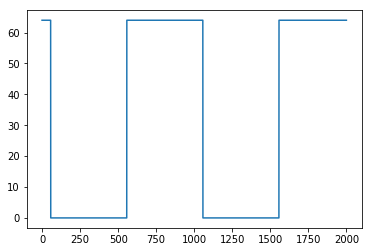

In [11]:
plot_ms = 2000
plt.plot(t_ms[t_ms<plot_ms], data_mmap[-1, t_ms<plot_ms])

#### same for the nidq file
More detailed meta here https://github.com/billkarsh/SpikeGLX/blob/master/Markdown/Metadata.md.
- 

In [273]:
bin_file_path = os.path.join('/mnt/microdrive/birds/stimsim/Ephys/2019-05-27_stimsim_0000_00_g0/', '2019-05-27_stimsim_0000_00_g0_t0.nidq.bin')
bin_file_path = os.path.join('/Users/zeke/experiment/stimsim/Ephys/2019-05-27_stimsim_0000_00_g0/', '2019-05-27_stimsim_0000_00_g0_t0.nidq.bin')

meta_file_path = os.path.join('/Users/zeke/experiment/stimsim/Ephys/2019-05-27_stimsim_0000_00_g0/', '2019-05-27_stimsim_0000_00_g0_t0.nidq.meta')

#bin_file_path = '/mnt/microdrive/birds/neuropixtests/run1_g0/run1_g0_t0.nidq.bin'
# these should come from the .meta file
reload(sglu)
# these should come from the .meta file
nidq_meta_dict = sglu.get_nidq_meta(meta_file_path)

n_chan_nidq = nidq_meta_dict['nsavedchans'] #nSavedChans in meta file
s_f_nidq = nidq_meta_dict['nisamprate'] #nidqSampleRate in meta file
n_chan_list = nidq_meta_dict['sns_mn_ma_xa_dw'] #acqMnMaXaDw - The two last are the relevant. We have no multiplexed channels (Whisper system); those will always be zeros, or should be.
n_adc_chan = n_chan_list[2]
n_dig_word = n_chan_list[3]

#this is the whole block, including all four types of channels
data_mmap_nidq = np.memmap(bin_file_path, dtype='int16', mode='r').reshape(n_chan_nidq, -1, order='f')
n_sample_nidq = data_mmap_nidq.shape[1]
t_ms_nidq = np.arange(n_sample_nidq)/s_f_nidq * 1000
# this yields an array shaped [n_ch, n_sample]

In [274]:
ni_data = sglu.get_ni_data(meta_file_path)

2019-06-03 01:28:15,801 - pipefinch.pipeline.sglxutil - INFO - {'meta': {'nsavedchans': 9, 'nisamprate': 20000.190251, 'sns_mn_ma_xa_dw': [0, 0, 8, 1]}, 't_ms': None, 'adc': None, 'din': None}


/Users/zeke/experiment/stimsim/Ephys/2019-05-27_stimsim_0000_00_g0/2019-05-27_stimsim_0000_00_g0_t0.nidq


In [276]:
ni_data['din']

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [268]:
import warnings
warnings.warn('tu vieja')

/Users/zeke/anaconda3/envs/mountain/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: tu vieja
  


In [ ]:
# so get the digital channels
# consider they are big endian to the extent of the .view() method.
# In our case,there are 8 bits that matter (for the NI6221), but sglx uses entire bytes.
# Hence, there is one whole byte with the DIN, which needs to be unpacked and only 8 bytes used.
# Python has a sweet np.unpackbits() method for that, but only works with uint8.
# So we need to cast it as a big_endian, 16 bit, and se the view() method to allow for np.uint8 input.

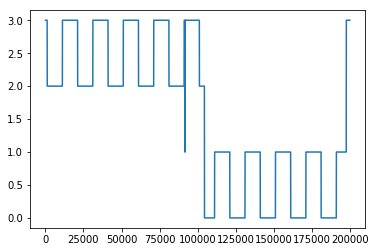

In [63]:
## get the digital channels (the last 2-byte word in the data block). We had already read in 2-byte words, so it is the last word.
dig_stream = data_mmap_nidq[-1].astype(np.uint16)
dig_stream.shape
plt.plot(dig_stream[:20000*10])

In [197]:
# unpack.
# cast as big_endian, view as np.uint8 and reshape to [n_sample, n_chan]
# (see accepted answer in https://stackoverflow.com/questions/18296035/how-to-extract-the-bits-of-larger-numeric-numpy-data-types)
all_dig_stream_16 = np.unpackbits(dig_stream.astype('>i2').view(np.uint8))
# that one is a 1D array of 16 bits. we need to reshape and get rid of the 8 empty bits and reverse the order of those 8 bits,
# so that dig[0, ... 7] coincide with x[:, 0...7]
# order 'F' avoids having to transpose and the final array is [n_ch, n_sample]
all_dig_stream = all_dig_stream_16.reshape([8, 2, -1], order='f')[::-1,1,:]

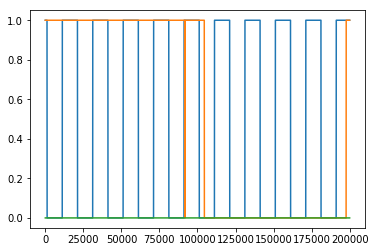

In [198]:
plt.plot(all_dig_stream[0, :20000*10])
plt.plot(all_dig_stream[1, :20000*10])
plt.plot(all_dig_stream[2, :20000*10])

In [199]:
#plot syn channels and check alignment

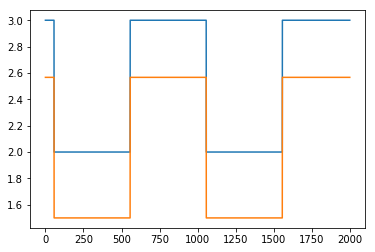

In [200]:
plot_ms = 2000
plt.plot(t_ms_nidq[t_ms_nidq<plot_ms], data_mmap_nidq[-1, t_ms_nidq<plot_ms])
plt.plot(t_ms[t_ms<plot_ms], data_mmap[-1, t_ms<plot_ms]/60+1.5)

In [201]:
dig_arr.shape

(9044424,)

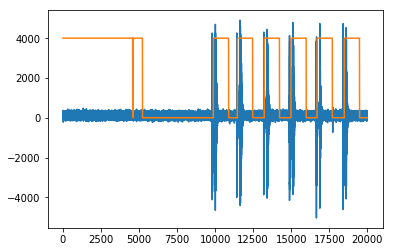

In [202]:
# plot mic chan together with the dig_in
mic_chan = 0
plot_ms = 20000

trig_chan = 1

plt.plot(t_ms_nidq[t_ms_nidq<plot_ms], data_mmap_nidq[mic_chan, t_ms_nidq<plot_ms])
plt.plot(t_ms_nidq[t_ms_nidq<plot_ms], all_dig_stream[trig_chan, t_ms_nidq<plot_ms]*4000)

In [ ]:
# find the edges

In [213]:
np.where(np.diff(all_dig_stream[0]))[0]

array([   1128,   11129,   21129,   31129,   41129,   51129,   61129,
         71129,   81129,   91129,  101129,  111130,  121130,  131130,
        141130,  151130,  161130,  171130,  181130,  191130,  201130,
        211130,  221131,  231131,  241131,  251131,  261131,  271131,
        281131,  291131,  301131,  311131,  321131,  331132,  341132,
        351132,  361132,  371132,  381132,  391132,  401132,  411132,
        421132,  431133,  441133,  451133,  461133,  471133,  481133,
        491133,  501133,  511133,  521133,  531133,  541134,  551134,
        561134,  571134,  581134,  591134,  601134,  611134,  621134,
        631134,  641135,  651135,  661135,  671135,  681135,  691135,
        701135,  711135,  721135,  731135,  741135,  751136,  761136,
        771136,  781136,  791136,  801136,  811136,  821136,  831136,
        841136,  851137,  861137,  871137,  881137,  891137,  901137,
        911137,  921137,  931137,  941137,  951137,  961138,  971138,
        981138,  991